In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

unbind (generic function with 2 methods)

In [3]:
using Plots

In [4]:
repeats = 6

6

In [5]:
tspan = (0.0, 1.0 * repeats)

(0.0, 6.0)

In [6]:
n_angles = 101

101

In [7]:
phase_0 = reshape([0.0], (1,1))

1×1 Matrix{Float64}:
 0.0

In [8]:
phases = reshape(range(start = -1.0, stop = 1.0, length = n_angles) |> collect, (1, n_angles))

1×101 Matrix{Float64}:
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  1.0

In [9]:
s = similarity(phase_0, phases, dim=1)

1×101 Matrix{Float64}:
 -1.0  -0.998027  -0.992115  -0.982287  …  -0.992115  -0.998027  -1.0

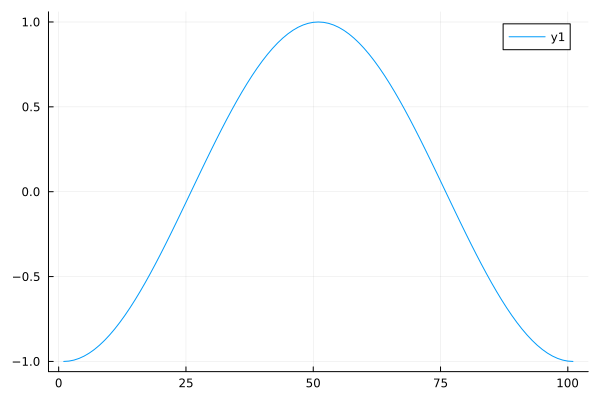

In [10]:
plot(s |> vec)

In [11]:
cmpx(x) = exp.(0.0 + 1.0im * pi * x)

cmpx (generic function with 1 method)

In [12]:
c_phase0 = cmpx.(phase_0)
c_phase = cmpx.(phases);

In [13]:
cmpx_interference = c_phase0 .+ c_phase;

In [14]:
absvals = abs.(cmpx_interference)

1×101 Matrix{Float64}:
 1.22465e-16  0.0628215  0.125581  …  0.125581  0.0628215  1.22465e-16

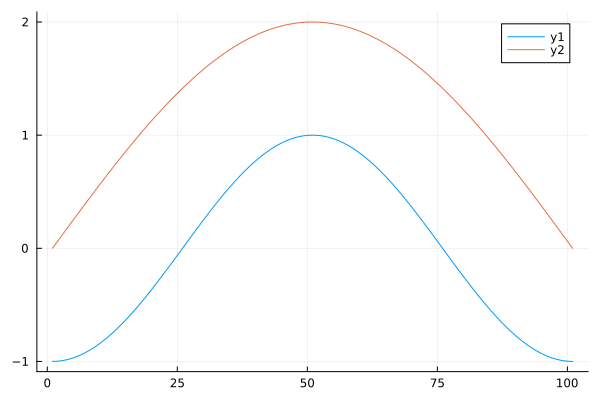

In [15]:
plot(s |> vec)
plot!(absvals |> vec)

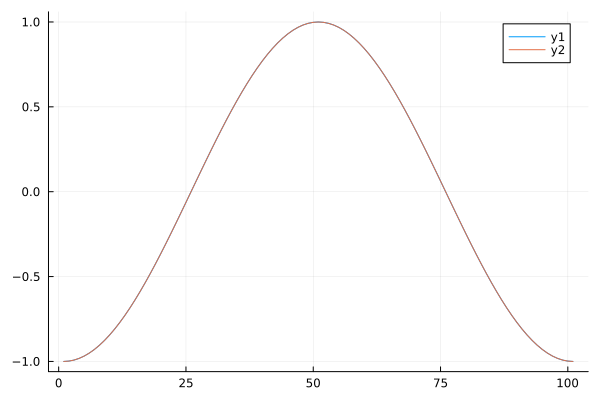

In [16]:
plot(s |> vec)
plot!(cos.(2 .* acos.((absvals |> vec) ./ 2)))

In [17]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [18]:
st_0 = phase_to_train(phase_0, spk_args, repeats = repeats)
st_p = phase_to_train(phases, spk_args, repeats = repeats)

Spike Train: (1, 101) with 606 spikes.

In [19]:
using OrdinaryDiffEq

In [20]:
sol_0 = phase_memory(st_0, tspan=tspan, spk_args=spk_args);

In [21]:
sol_phase = phase_memory(st_p, tspan=tspan, spk_args=spk_args);

In [22]:
tbase = tspan[1]:spk_args.dt:tspan[2] |> collect;

In [23]:
sol_analytic = phase_to_potential(phases, tbase, 0.0, spk_args);

In [24]:
u_phase = Array(sol_phase);

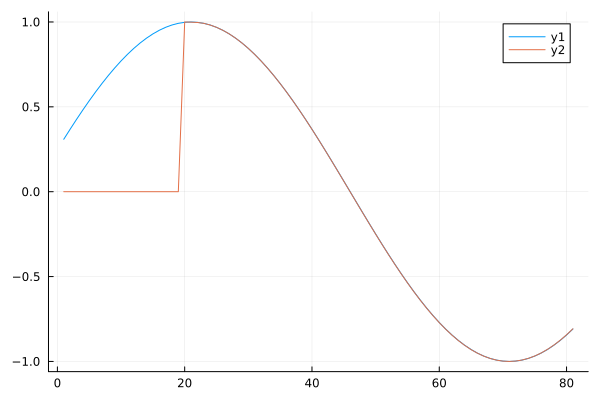

In [25]:
plot(real.(sol_analytic[1,21,1:81]))
plot!(real.(normalize_potential.(u_phase[1,21,1:81])))

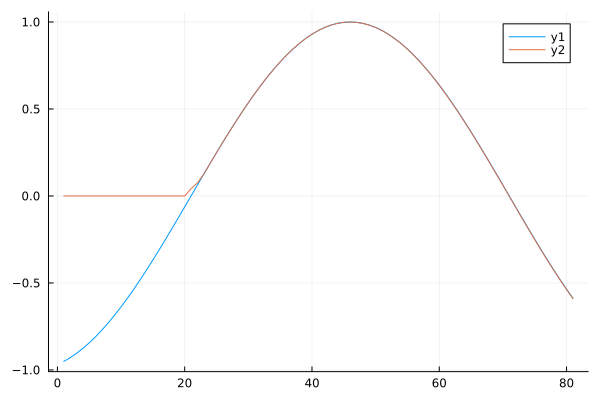

In [26]:
plot(imag.(sol_analytic[1,21,1:81]))
plot!(imag.(normalize_potential.(u_phase[1,21,1:81])))

In [27]:
phases[21]

-0.6

In [28]:
phases[21] - phases[51]

-0.6

In [29]:
a1 = angle(u_phase[1,21,101])

-1.2534072f0

In [30]:
a2 = angle(u_phase[1,51,101])

-3.076732f0

In [31]:
da = (a2 - a1) / pi

-0.5803822f0

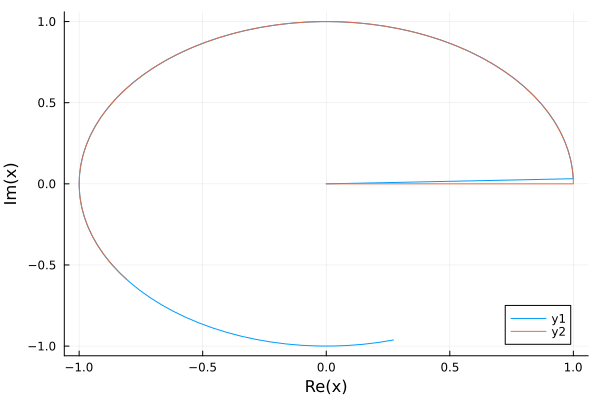

In [32]:
plot(normalize_potential.(u_phase[1,1,1:81]))
plot!(normalize_potential.(u_phase[1,21,1:81]))

In [33]:
rec_phases_analytic = potential_to_phase(sol_analytic, tbase, dim=3, spk_args=spk_args);

In [34]:
rec_phases_memory = potential_to_phase(u_phase, tbase, dim=3, spk_args=spk_args);

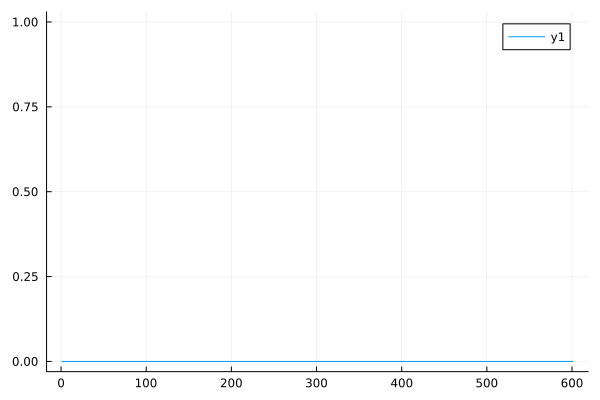

In [35]:
plot(rec_phases_analytic[1,51,:])

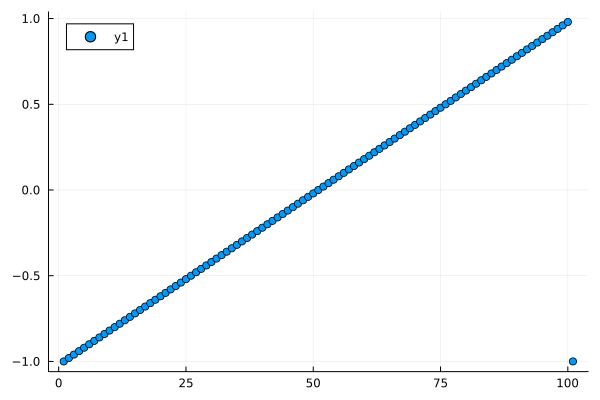

In [36]:
scatter(rec_phases_analytic[1,:,end])

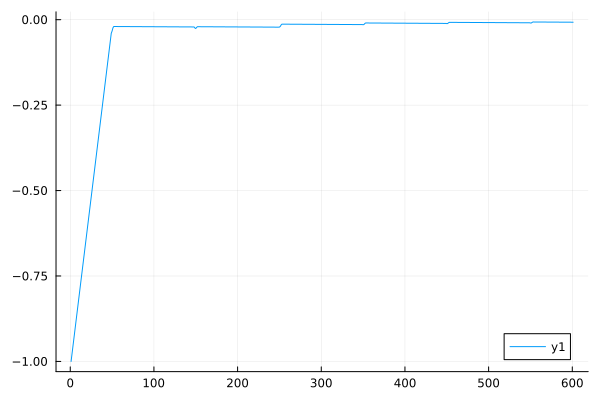

In [37]:
plot(rec_phases_memory[1,51,:])

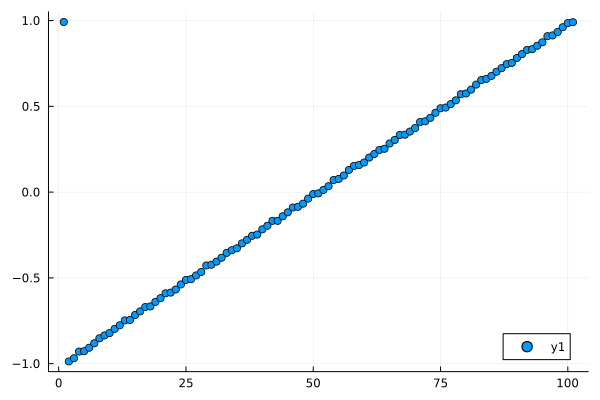

In [38]:
scatter(rec_phases_memory[1,:,end])

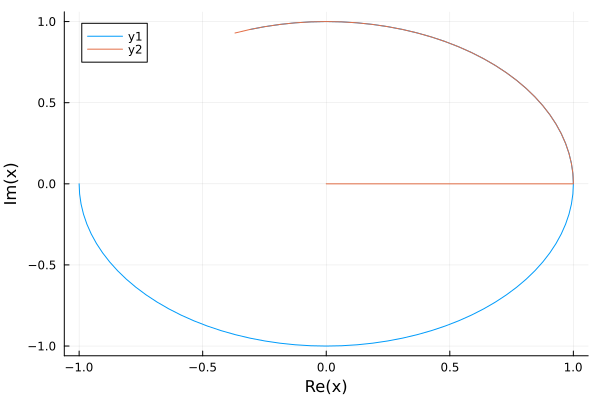

In [39]:
plot(sol_analytic[1,51,1:81])
plot!(normalize_potential.(u_phase[1,51,1:81]))

In [40]:
sol_phase |> size

(1, 101, 601)

In [41]:
decoded = potential_to_phase(Array(sol_phase), sol_phase.t, dim=3, spk_args=spk_args);

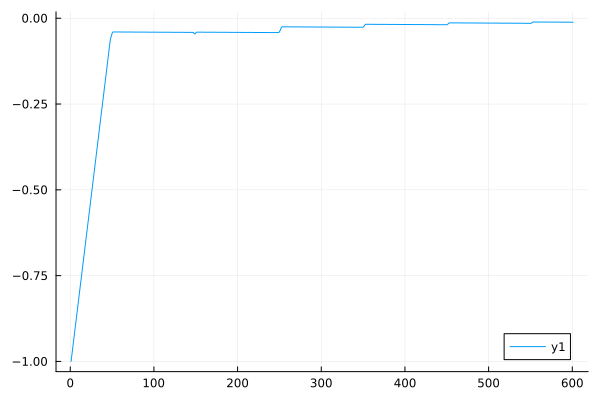

In [42]:
plot(decoded[1,50,:])

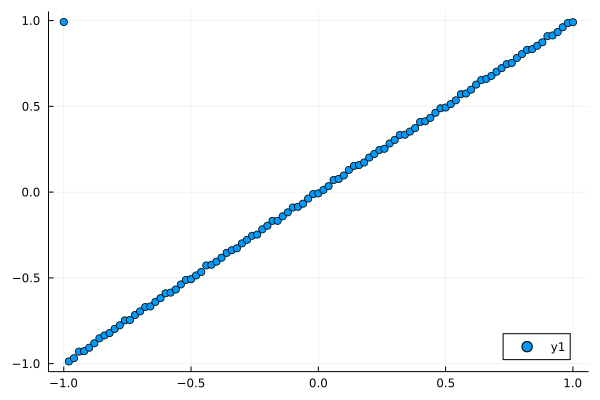

In [43]:
scatter(phases |> vec, decoded[1,:,end] |> vec)

In [49]:
phase_err = (phases |> vec) .- (decoded[1,:,end] |> vec);

In [48]:
ang_err = sin.(2*pi .* phase_err);

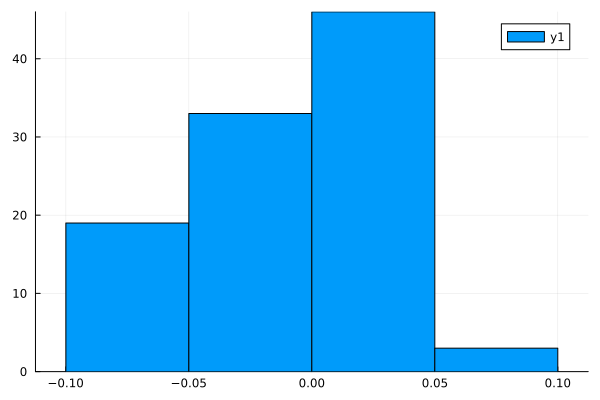

In [47]:
histogram(ang_err)

In [51]:
mean(ang_err)

-0.000642587599678694

In [50]:
sol_0

retcode: Success
Interpolation: 3rd order Hermite
t: 601-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.060000000000000005
 0.07
 0.08
 0.09
 0.09999999999999999
 0.10999999999999999
 0.11999999999999998
 ⋮
 5.889999999999919
 5.899999999999919
 5.909999999999918
 5.919999999999918
 5.929999999999918
 5.939999999999918
 5.949999999999918
 5.959999999999917
 5.969999999999917
 5.979999999999917
 5.989999999999917
 6.0
u: 601-element Vector{Matrix{ComplexF32}}:
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 [0.0f0 + 0.0f0im;;]
 ⋮
 [-0.08381579f0 + 0.06617675f0im;;]
 [-0.087632574f0 + 0.06065813f0im;;]
 [-0.091088146f0 + 0.054922096f0im;;]
 [-0.09417031f0 + 0.04899216f0im;;]
 [-0.09686838f0 + 0.04289251f0im;;]
 [-0.099173255f0 + 0.036647897f0im;;]
 [-0.1010774f0 + 0.0302

In [45]:
u_0 = Array(sol_0)
u_phase = Array(sol_phase);

In [46]:
interference = normalize_potential.(u_0) .+ normalize_potential.(u_phase);

In [47]:
interference |> size

(1, 101, 601)

In [48]:
mag = abs.(interference);

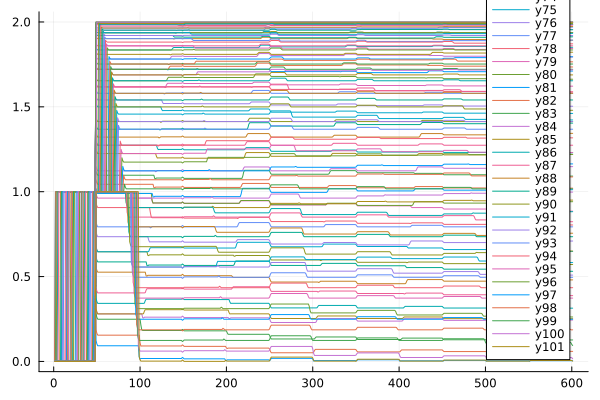

In [49]:
plot(mag[1,:,:]')

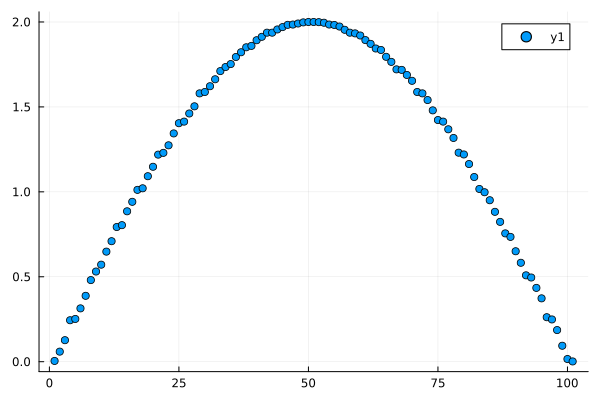

In [50]:
scatter(mag[1,:,end])

In [51]:
sim_spiking = cos.( 2.0 .* acos.(0.5 .* mag[1,:,end]))

101-element Vector{Float64}:
 -0.9999899398606041
 -0.9982452360364423
 -0.9919799616453052
 -0.9702058988773512
 -0.9683163499029876
 -0.9507122805342045
 -0.9247787498944273
 -0.8845576779554262
 -0.8590870868178443
 -0.8368526751550861
  ⋮
 -0.8771433098667313
 -0.9055838406422647
 -0.9304457614471175
 -0.9657078457265396
 -0.9690551795529418
 -0.9826501283603508
 -0.9955913604806391
 -0.9998761357034017
 -0.9999987269260431

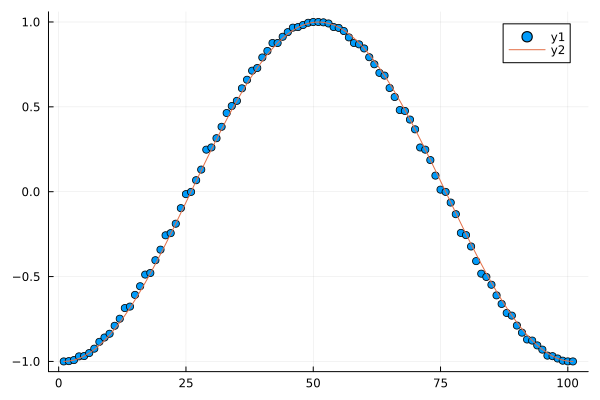

In [52]:
scatter(sim_spiking)
plot!(s |> vec)

In [53]:
err = vec(sim_spiking) .- vec(s);

In [54]:
err |> size

(101,)

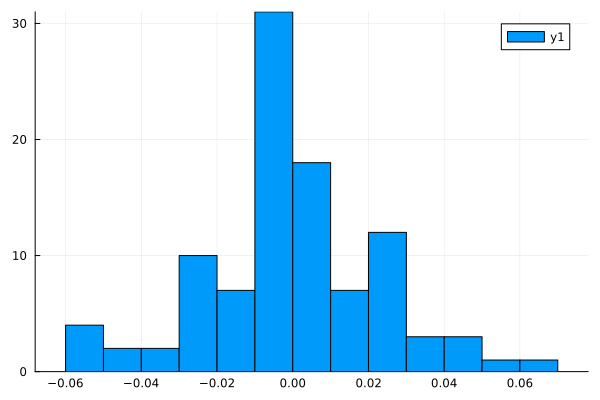

In [55]:
histogram(err |> vec)